In [1]:
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
from icecream import ic
from typing import Tuple, Any, List, Union, Literal
from sklearn.linear_model import LinearRegression

In [2]:
def make_probability(vector: np.ndarray) -> np.ndarray:
    """
    From the distribution dist, generate a probability vector that sums to 1. 
    """
    return vector / vector.sum()

In [3]:
class MultiArmBandit:
    """
    3-armed Bandit
    """    
    def __init__(self, prob1: np.ndarray, prob2: np.ndarray, prob3: np.ndarray, rewards: Union[List, np.ndarray]):
        self.prob1 = prob1
        self.prob2 = prob2
        self.prob3 = prob3
        self.rewards = rewards

        self.action_sequence = []
        self.reward_sequence = []
        self.cum_reward_sequence = []
        self.t = 0

        self.true_means = self.get_action_true_mean_rewards()

        self.optimal_action = np.argmax(self.true_means) + 1
        self.optimal_reward = np.max(self.true_means)


    def get_action_true_mean_rewards(self) -> List[float]:
        """
        Use probability distributions and reward values to calculate 
        true mean rewards for each action
        """
        mu1 = np.dot(self.rewards, self.prob1) 
        mu2 = np.dot(self.rewards, self.prob2) 
        mu3 = np.dot(self.rewards, self.prob3) 

        return [mu1, mu2, mu3]
    

    def get_reward(self, prob: np.ndarray) -> int:
        """
        For a given probability vector, generate a reward. 
        """
        cumulative_prob = np.cumsum([0] + list(prob))

        u = stats.uniform.rvs(0, 1)
        for i in range(1, len(cumulative_prob)):
            if u < cumulative_prob[i]:
                return self.rewards[i-1]


    def pull_arm(self, action: Literal[1, 2, 3]) -> int:
        """
        For the given probability vectors and action, generate a reward. 
        """
        probs = [self.prob1, self.prob2, self.prob3]   # Probabilities of action 1, 2, and 3
        reward = self.get_reward(probs[action - 1])

        self.action_sequence.append(action)
        self.reward_sequence.append(reward)

        if not self.cum_reward_sequence:
            self.cum_reward_sequence.append(reward)
        else:
            self.cum_reward_sequence.append(self.cum_reward_sequence[-1] + reward)

        self.t += 1

        return reward
    

    def calculate_cumulative_regret(self) -> np.ndarray:
        """
        Calculate the cumulative regret for the action sequence. 
        """
        true_mean_rewards_by_action = [self.true_means[a - 1] for a in self.action_sequence]
        instantaneous_regrets = [(self.optimal_reward - true_mean) for true_mean in true_mean_rewards_by_action]
        cumulative_regret = np.cumsum(instantaneous_regrets)

        return cumulative_regret

    
def random_action() -> int:
    """
    Generate a random action (integer) in the range [1, 3].
    """
    return np.random.randint(1, 4)
    

def explore_then_commit(action_sequence: List[int], reward_sequence: List[int], exploration_len: int) -> int:
    """
    Using the Explore-Then-Commit algorithm, generate the next output action 
    given the action sequence, reward sequence, and length of exploration. 
    """

    if len(action_sequence) <= 3 * exploration_len:
        next_action = len(action_sequence) % 3 + 1
    else:
        # Calculate the empirical mean reward for each action for the exploration phase
        exploration_actions = np.array(action_sequence)[:3 * exploration_len]
        exploration_rewards = np.array(reward_sequence)[:3 * exploration_len]
        # Get reward_sequence where action = 1
        mu1_hat = np.mean(exploration_rewards[exploration_actions == 1]) 
        # Get reward_sequence where action = 2
        mu2_hat = np.mean(exploration_rewards[exploration_actions == 2]) 
        # Get reward_sequence where action = 3
        mu3_hat = np.mean(exploration_rewards[exploration_actions == 3]) 

        next_action = np.argmax([mu1_hat, mu2_hat, mu3_hat]) + 1
    
    return next_action


def get_optimum_exploration_len(prob1: np.ndarray, prob2: np.ndarray, prob3: np.ndarray, rewards: Union[List, np.ndarray], horizon: int):
    """
    Calculate optimal exploration length based on reward distributions and horizon. 
    """
    # Calculate delta as the difference between the best and the second best arms
    # mu = E[X_t] = Sum(X_t * P(X_t))
    action1_true_mean = np.dot(rewards, prob1) 
    action2_true_mean = np.dot(rewards, prob2) 
    action3_true_mean = np.dot(rewards, prob3) 

    # Calculate the suboptimality gap
    true_means = [action1_true_mean, action2_true_mean, action3_true_mean]
    idx = np.argsort(true_means)
    sorted_means = np.array(true_means)[idx]
    delta = sorted_means[2] - sorted_means[1]

    T = horizon
    R = max(rewards) - min(rewards)
    delta_sq = delta ** 2
    R_sq = R ** 2
    log_term = (2 * T * delta_sq)/R_sq
    coeff = (R_sq / (2 * delta_sq))
    
    optimal_exploration_len = coeff * np.log(log_term)

    return math.ceil(optimal_exploration_len)


def upper_confidence_bound(action_sequence, reward_sequence):
    def find_confidence_interval(R, delta, n):
        if n == 0:
            return float("inf")
        log = math.log(1 / delta)
        return R * math.sqrt(log / (2 * n))


    action_sequence = np.array(action_sequence)
    reward_sequence = np.array(reward_sequence)
    
    action1_rewards = reward_sequence[action_sequence == 1]
    action2_rewards = reward_sequence[action_sequence == 2]
    action3_rewards = reward_sequence[action_sequence == 3]

    action1_mean = np.mean(action1_rewards)
    action2_mean = np.mean(action2_rewards)
    action3_mean = np.mean(action3_rewards)

    N1t = np.sum(action_sequence == 1)
    N2t = np.sum(action_sequence == 2)
    N3t = np.sum(action_sequence == 3)

    R = 10
    delta = 0.01
    action1_confidence = find_confidence_interval(R, delta, N1t)
    action2_confidence = find_confidence_interval(R, delta, N2t)
    action3_confidence = find_confidence_interval(R, delta, N3t)

    action1_width = action1_mean + action1_confidence
    action2_width = action2_mean + action2_confidence
    action3_width = action3_mean + action3_confidence

    best_action = np.argmax([action1_width, action2_width, action3_width]) + 1

    return best_action


def thompson_sampling(action_sequence, reward_sequence):
    action_sequence = np.array(action_sequence)
    reward_sequence = np.array(reward_sequence)
    
    # Get rewards for each action
    action1_rewards = reward_sequence[action_sequence == 1]
    action2_rewards = reward_sequence[action_sequence == 2]
    action3_rewards = reward_sequence[action_sequence == 3]

    # Use beta distribution 
    alphas = np.ones(3)
    betas = np.ones(3)

    # Update the distribution based on rewards
    for action_idx, rewards in enumerate([action1_rewards, action2_rewards, action3_rewards]):
        if len(rewards) > 0:
            scaled_rewards = rewards / 10
            alphas[action_idx] += np.sum(scaled_rewards)
            betas[action_idx] += np.sum(1 - scaled_rewards)


    samples = [np.random.beta(alphas[i], betas[i]) * 10 for i in range(3)]

    best_action = np.argmax(samples) + 1

    return best_action

In [4]:
# Vector used to generate distribution
d1 = np.array([1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610])
prob1 = make_probability((d1 + d1[::-1])[:10])

# Vector used to generate distribution
d2 = np.histogram(np.random.normal(0, 4, 10000), bins=51)[0][5:15]
prob2 = make_probability(abs(d2))

prob3 = make_probability((d1 + d1[::-1])[3:13])

rewards = np.arange(1, 11)

params = {
    "prob1": prob1, 
    "prob2": prob2, 
    "prob3": prob3, 
    "rewards": rewards
}

T = 2000
etc_optimal_m = get_optimum_exploration_len(horizon=T, **params)
etc_optimal_m

61

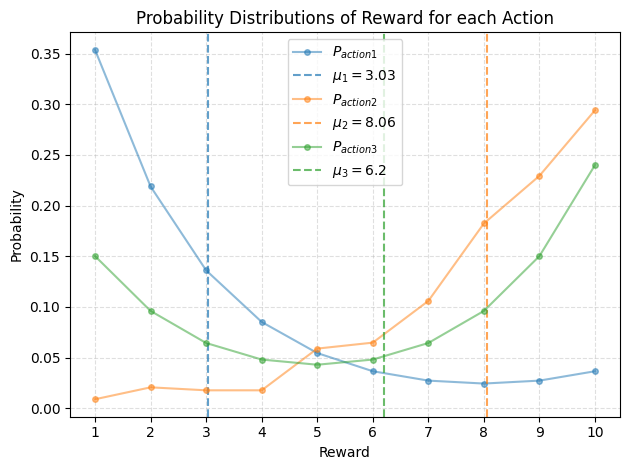

In [5]:
# plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(1, 1)
line1, = ax.plot(rewards, prob1, label="$P_{action1}$", alpha=0.5, marker="o", markersize=4)
mu1 = round(np.dot(prob1, np.arange(1, 11)), 2)
ax.axvline(mu1, label=f"$\mu_{1} = {mu1}$", ls="--", color=line1.get_color(), alpha=0.7)

line2, = ax.plot(rewards, prob2, label="$P_{action2}$", alpha=0.5, marker="o", markersize=4)
mu2 = round(np.dot(prob2, np.arange(1, 11)), 2)
ax.axvline(mu2, label=f"$\mu_{2} = {mu2}$", ls="--", color=line2.get_color(), alpha=0.7)

line3, = ax.plot(rewards, prob3, label="$P_{action3}$", alpha=0.5, marker="o", markersize=4)
mu3 = round(np.dot(prob3, np.arange(1, 11)), 2)
ax.axvline(mu3, label=f"$\mu_{3} = {mu3}$", ls="--", color=line3.get_color(), alpha=0.7)

ax.set_title("Probability Distributions of Reward for each Action")
ax.set_xlabel("Reward")
ax.set_ylabel("Probability")
ax.set_xticks([_ for _ in range(1, 11)])
ax.legend()
ax.grid(alpha=0.4, ls="--")
plt.tight_layout()
plt.show()

In [6]:
exploration_lens = [10, 100, 500, etc_optimal_m]

simulated_etc_bandits = dict()

for m in exploration_lens:
    # Create a new bandit for each exploration length. 
    etc_bandit = MultiArmBandit(**params)

    # For each exploration length (m), run the simulation for 
    # a horizon of T for the bandit. 
    for _ in range(T):
        etc_action = explore_then_commit(
            action_sequence=etc_bandit.action_sequence, 
            reward_sequence=etc_bandit.reward_sequence, 
            exploration_len=m
            )
        etc_bandit.pull_arm(etc_action)

    simulated_etc_bandits[m] = etc_bandit

In [7]:
ucb_bandit = MultiArmBandit(**params)

for _ in range(T):
    ucb_action = upper_confidence_bound(ucb_bandit.action_sequence, ucb_bandit.reward_sequence)
    ucb_bandit.pull_arm(ucb_action)

/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aryan/miniconda3/envs/dsml/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
ts_bandit = MultiArmBandit(**params)

for _ in range(T):
    ts_action = thompson_sampling(ts_bandit.action_sequence, ts_bandit.reward_sequence)
    ts_bandit.pull_arm(ts_action)

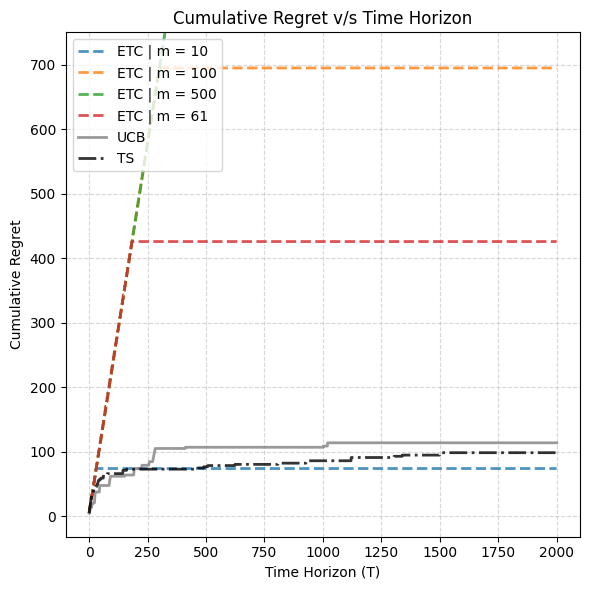

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for m, bandit in simulated_etc_bandits.items():
    # if m < 500:
    etc_running_cum_regret = bandit.calculate_cumulative_regret()

    ax.plot(np.arange(0, 2000), etc_running_cum_regret, label=f"ETC | m = {m}", alpha=0.8, ls="--", lw=2)

ucb_running_cum_regret = ucb_bandit.calculate_cumulative_regret()
ax.plot(np.arange(0, 2000), ucb_running_cum_regret, label=f"UCB", alpha=0.8, color="gray", lw=2)

ts_running_cum_regret = ts_bandit.calculate_cumulative_regret()
ax.plot(np.arange(0, 2000), ts_running_cum_regret, label=f"TS", alpha=0.8, color="black", ls="-.", lw=2)

ax.set_title("Cumulative Regret v/s Time Horizon")
ax.set_xlabel("Time Horizon (T)")
ax.set_ylabel("Cumulative Regret")
ax.grid(alpha=0.5, ls="--")
ax.legend()
ax.set_ylim(-31.662180256856022, 750)
plt.tight_layout()
plt.show()

From the above graph, we can see that the explore-then-commit algorithm's regret grows as the exploration length (M) grows relative to the time horizon (T). ETC with m=10 has the lowest cumulative regret out of all the strategies because it is (by chance) able to pick out the optimal arm during the exploration phase, which it then exploits for more rounds than any other strategy. 

The regret for UCB is much better compared to that of the optimal exploration length for ETC (less than half). Thompson sampling is able to beat UCB by a small margin. 

# Problem 2

In [10]:
class LinBandit:
    def __init__(self, theta_star):
        self.theta_star = theta_star

        self.action_sequence = []
        self.reward_sequence = []
        self.cum_reward_sequence = []
    
    def pull_arm(self, action):
        reward = np.dot(self.theta_star, action) + np.random.normal(0, 1)

        self.action_sequence.append(action)
        self.reward_sequence.append(reward)

        if not self.cum_reward_sequence:
            self.cum_reward_sequence.append(reward)
        else:
            self.cum_reward_sequence.append(self.cum_reward_sequence[-1] + reward)

        return reward    

In [11]:
def etc_for_linbandit(action_sequence, reward_sequence, m, theta_hat=None):
    t = len(action_sequence)
    action = None

    if t < m:
        action = np.random.uniform(0, 1, 10)
        action = action / np.linalg.norm(action)
    else:
        if theta_hat is None:
            model = LinearRegression()
            model.fit(action_sequence, reward_sequence)
            theta_hat = model.coef_

        # To maximize the reward, we need to maximize <theta^, A_t>. 
        # This is done when the angle between them is the same. 
        # Since A_t lies on a unit ball, we set the action as normalized theta^
        action = theta_hat / np.linalg.norm(theta_hat)

    return action, theta_hat


def ts_for_linbandit(action_sequence, reward_sequence, lambda_prior):
    t = len(action_sequence)
    if t == 0:
        x = np.random.normal(0, 1, 10)
        return x / np.linalg.norm(x)
    
    action_sequence = np.array(action_sequence)
    reward_seqeunce = np.array(reward_sequence)

    V = action_sequence.T @ action_sequence + lambda_prior * np.eye(10)
    V_inv = np.linalg.inv(V)
    theta_hat = V_inv @ action_sequence.T @ reward_seqeunce

    theta_sample = np.random.multivariate_normal(
        mean=theta_hat, 
        cov=(1 ** 2) * V_inv
    )

    return theta_sample / np.linalg.norm(theta_sample)
    


In [12]:
exploration_lens = [10, 100, 500, 1000]
theta_star = np.random.normal(0, 1, 10)
theta_start = theta_star / np.linalg.norm(theta_star)

simulated_etc_linbandits = dict()

T = 2000

for m in exploration_lens:
    # Create a new bandit for each exploration length. 
    theta_hat = None
    etc_linbandit = LinBandit(theta_star=theta_star)

    # For each exploration length (m), run the simulation for 
    # a horizon of T for the bandit. 
    for _ in range(T):
        etc_action, theta_hat = etc_for_linbandit(
            action_sequence=etc_linbandit.action_sequence, 
            reward_sequence=etc_linbandit.reward_sequence, 
            m=m, 
            theta_hat=theta_hat
            )
        etc_linbandit.pull_arm(etc_action)

    simulated_etc_linbandits[m] = etc_linbandit

In [13]:
ts_linbandit = LinBandit(theta_star=theta_star)

for _ in range(T):
    ts_action = ts_for_linbandit(
        ts_linbandit.action_sequence, 
        ts_linbandit.reward_sequence, 
        1
    )

    ts_linbandit.pull_arm(ts_action)

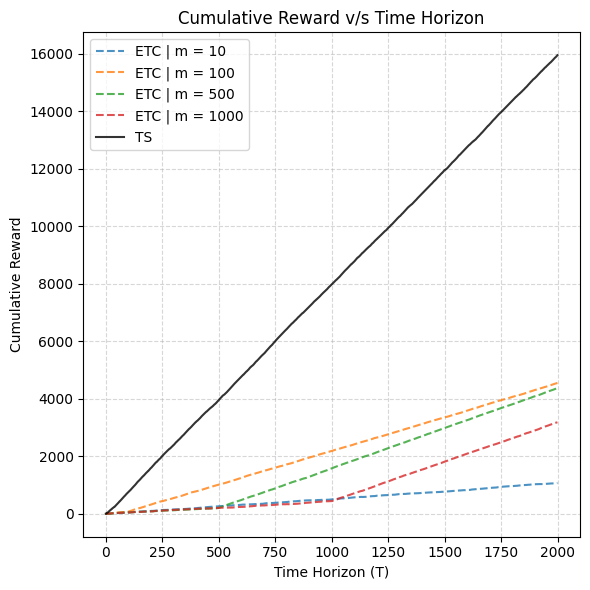

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for m, bandit in simulated_etc_linbandits.items():
    cum_reward = bandit.cum_reward_sequence
    ax.plot(cum_reward, label=f"ETC | m = {m}", alpha=0.8, ls="--")

ts_running_cum_reward = ts_bandit.cum_reward_sequence
ax.plot(ts_running_cum_reward, label=f"TS", alpha=0.8, color="black")

ax.set_title("Cumulative Reward v/s Time Horizon")
ax.set_xlabel("Time Horizon (T)"
              )
ax.set_ylabel("Cumulative Reward")
ax.grid(alpha=0.5, ls="--")
ax.legend()
plt.tight_layout()
plt.show()

We see that with ETC, not exploring much leads to low cumulative rewards. However, exploring for too long leads to a delayed increase in the slope, which means that at the end, rewards are much lower compared to moderate exploration. 

Thompson sampling outperforms ETC by a very large margin (~4x the cumulative rewards). This is because it automatically accounts for exploration through the randomness. 